In [1]:
from firedrake import *
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
mesh = UnitSquareMesh(40, 40, quadrilateral=True)

V = FunctionSpace(mesh, "DG", 0)
W = VectorFunctionSpace(mesh, "CG", 1)

x, y = SpatialCoordinate(mesh)

velocity = as_vector(( (0.5 - y ), ( x - 0.5) ))
u = Function(W).interpolate(velocity)

In [3]:
bell_r0 = 0.15; bell_x0 = 0.25; bell_y0 = 0.5
cone_r0 = 0.15; cone_x0 = 0.5; cone_y0 = 0.25
cyl_r0 = 0.15; cyl_x0 = 0.5; cyl_y0 = 0.75
slot_left = 0.475; slot_right = 0.525; slot_top = 0.85

bell = 0.25*(1+cos(math.pi*min_value(sqrt(pow(x-bell_x0, 2) + pow(y-bell_y0, 2))/bell_r0, 1.0)))
cone = 1.0 - min_value(sqrt(pow(x-cone_x0, 2) + pow(y-cone_y0, 2))/cyl_r0, 1.0)
slot_cyl = conditional(sqrt(pow(x-cyl_x0, 2) + pow(y-cyl_y0, 2)) < cyl_r0,
             conditional(And(And(x > slot_left, x < slot_right), y < slot_top),
               0.0, 1.0), 0.0)

In [4]:
q = Function(V).interpolate(1.0 + bell + cone + slot_cyl)
q_init = Function(V).assign(q)

qs = []
T = 2*math.pi
dt = T/1200
dtc = Constant(dt)
q_in = Constant(1.0)

dq_trial = TrialFunction(V)
phi = TestFunction(V)
a = phi*dq_trial*dx

n = FacetNormal(mesh)
un = 0.5*(dot(u, n) + abs(dot(u, n)))

In [5]:
L1 = dtc*(q*div(phi*u)*dx
          - conditional(dot(u, n) < 0, phi*dot(u, n)*q_in, 0.0)*ds
          - conditional(dot(u, n) > 0, phi*dot(u, n)*q, 0.0)*ds
          - (phi('+') - phi('-'))*(un('+')*q('+') - un('-')*q('-'))*dS)

q1 = Function(V); q2 = Function(V)
L2 = replace(L1, {q: q1}); L3 = replace(L1, {q: q2})


dq = Function(V)

In [6]:
params = {'ksp_type': 'preonly', 'pc_type': 'bjacobi', 'sub_pc_type': 'ilu'}
prob1 = LinearVariationalProblem(a, L1, dq)
solv1 = LinearVariationalSolver(prob1, solver_parameters=params)
prob2 = LinearVariationalProblem(a, L2, dq)
solv2 = LinearVariationalSolver(prob2, solver_parameters=params)
prob3 = LinearVariationalProblem(a, L3, dq)
solv3 = LinearVariationalSolver(prob3, solver_parameters=params)

In [7]:
t = 0.0
step = 0
output_freq = 20

if step % output_freq == 0:
    qs.append(q.copy(deepcopy=True))
    print("t=", t)
print(q.dat.data.max())

t= 0.0
2.0


In [8]:
while t < T - 0.5*dt:
    solv1.solve()
    q.assign(q + dq)

    #solv2.solve()
    #q2.assign(0.75*q + 0.25*(q1 + dq))

    #solv3.solve()
    #q.assign((1.0/3.0)*q + (2.0/3.0)*(q2 + dq))

    print(q.dat.data.max())
    step += 1
    t += dt

    if step % output_freq == 0:
        qs.append(q.copy(deepcopy=True))
        print("t=", t)

2.0
2.0
2.0
2.0
1.9999996954832837
1.9999982311999487
1.9999940094611584
1.9999845486050443
1.9999663869631705
1.999935027499114
1.9998849182717355
1.9998094639645754
1.999701063893871
1.9995511721396286
1.9993503757192796
1.999088487027176
1.998754647083664
1.9983374364651536
1.997898494137434
1.9973968485156561
t= 0.10471975511965971
1.996813016242917
1.9961393925483355
1.9953683111755218
1.9944921017469375
1.9935031482250778
1.9923939477406636
1.9911571690902778
1.989785710247879
1.9882727542838274
1.98661182313933
1.9847968287617361
1.9828221211653794
1.98068253304242
1.97837342060738
1.9758907004169277
1.9732308819623279
1.9703910958852953
1.96736911771839
1.9641633870982849
1.9607730224440227
t= 0.2094395102393196
1.9571978311326501
1.9534383152412889
1.9494956729578072
1.9453717957917935
1.9410692617436043
1.9365913246119495
1.931941899639921
1.9271255457156962
1.92214744435753
1.9170133757232268
1.912675259069282
1.910385386131952
1.9078250574236248
1.9050066043425518
1.9019421

0.19277243440355804


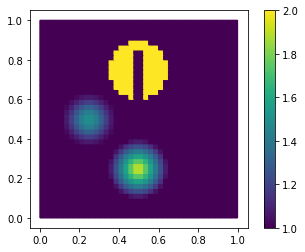

In [9]:

L2_err = sqrt(assemble((q - q_init)*(q - q_init)*dx))
L2_init = sqrt(assemble(q_init*q_init*dx))
print(L2_err/L2_init)

nsp = 16
fn_plotter = FunctionPlotter(mesh, num_sample_points=nsp)

fig, axes = plt.subplots()
axes.set_aspect('equal')
colors = tripcolor(q_init, num_sample_points=nsp, vmin=1, vmax=2, axes=axes)
fig.colorbar(colors)

def animate(q):
    colors.set_array(fn_plotter(q))

interval = 1e3 * output_freq * dt
animation = FuncAnimation(fig, animate, frames=qs, interval=interval)

try:
    animation.save("DG0_euler.mp4", writer="ffmpeg")
except:
    print("Failed to write movie! Try installing `ffmpeg`.")
